In [ ]:
import os
os.chdir("../Scripts")

In [ ]:
import gymnasium as gym
from agents.sample_averaging import ArmedBanditMaximizer
import matplotlib.pyplot as plt
from environments.simple import KArmedTestbed
import numpy as np

from tqdm.notebook import tqdm

gym.register(
    id="KArmedTestbed-V1",
    entry_point="environments.simple.KArmedTestbed",
    max_episode_steps=None
)

d:\DRL\.venv\Lib\site-packages\gymnasium\envs\registration.py:644: UserWarning: WARN: Overriding environment KArmedTestbed-V1 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [ ]:
num_steps = 1000
step_size_type = "academic"
seed=42
num_arms = 10
num_tests = 2000

train_env = KArmedTestbed(k=num_arms,
                          stationary=True,
                          stochastic_reward=True,
                          reward_means=[0.25, -0.75, 1.5, 0.4, 1.25, -1.5, 0.1, -1, 1, -0.5],
                          reward_stds=np.ones(shape=(num_arms, ))
                          )


def average_tests(env, epsilon, step_size_type, num_tests, num_steps):
    test_averages = []
    for _ in tqdm(range(num_tests)):
        maximizer = ArmedBanditMaximizer(
            env=env,
            epsilon=epsilon,
            step_size_type=step_size_type
        )

        train_env.reset()
        maximizer.learn(num_steps=num_steps, progress_bar=False)

        test_averages.append(maximizer.average_rewards)
    
    return np.average(test_averages, axis=0)

In [ ]:
greedy_rewards = average_tests(train_env, 0.0, step_size_type, num_tests, num_steps)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
epsilon_01_rewards = average_tests(train_env, 0.1, step_size_type, num_tests, num_steps)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
epsilon_001_rewards = average_tests(train_env, 0.01, step_size_type, num_tests, num_steps)

  0%|          | 0/2000 [00:00<?, ?it/s]

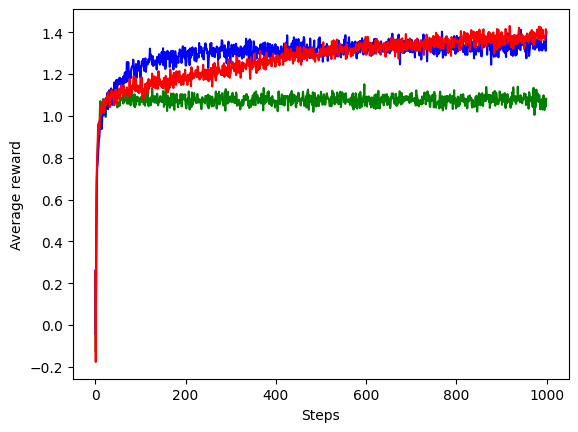

In [ ]:
fig, ax = plt.subplots()

ax.plot(greedy_rewards, color="green")
ax.plot(epsilon_01_rewards, color="blue")
ax.plot(epsilon_001_rewards, color="red")

ax.set_xlabel("Steps")
ax.set_ylabel("Average reward")

plt.show()